In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
#import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
# Parametreler ayarlanıyor
data_dir = "/content/drive/My Drive/Piton_Uygulamalarim/raylar"
batch_size = 32
img_height = 540
img_width = 120

In [22]:
# Eğitim Verisi Ayarlanıyor
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1810 files belonging to 2 classes.
Using 1448 files for training.


In [23]:
# Doğrulama Verisi Ayarlanıyor
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1810 files belonging to 2 classes.
Using 362 files for validation.


In [24]:
# Sınıf İsimleri Sorgulanıyor
class_names = train_ds.class_names
print(class_names)

['Kirik', 'Saglam']


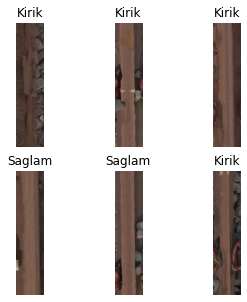

In [25]:
# Eğitim verilerinden 6 tanesini görüntüle
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
# Verileri Standartlaştırma [0, 1] aralığı
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print("Resim 1'deki en küçük piksel değeri:", np.min(first_image), "en büyük piksel değeri:", np.max(first_image))

Resim 1'deki en küçük piksel değeri: 0.003921569 en büyük piksel değeri: 0.6862745


In [27]:
# Veri örneklerini büyütme
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [40]:
# Modeli Oluşturalım
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.15), # Bırakma
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
# Modeli Derleyelim
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
# Model Özet Bilgileri
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 540, 120, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 540, 120, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 538, 118, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 269, 59, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 267, 57, 32)       4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 133, 28, 32)      0         
 g2D)                                                 

In [42]:
# Modelin Eğitilmesi
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
46/46 [==============================] - 75s 2s/step - loss: 0.7225 - accuracy: 0.5159 - val_loss: 0.6825 - val_accuracy: 0.5083
Epoch 2/20
46/46 [==============================] - 74s 2s/step - loss: 0.6665 - accuracy: 0.5836 - val_loss: 0.6142 - val_accuracy: 0.7072
Epoch 3/20
46/46 [==============================] - 74s 2s/step - loss: 0.5952 - accuracy: 0.6996 - val_loss: 0.5679 - val_accuracy: 0.6989
Epoch 4/20
46/46 [==============================] - 73s 2s/step - loss: 0.5662 - accuracy: 0.7072 - val_loss: 0.5197 - val_accuracy: 0.7293
Epoch 5/20
46/46 [==============================] - 74s 2s/step - loss: 0.5461 - accuracy: 0.7251 - val_loss: 0.5880 - val_accuracy: 0.6768
Epoch 6/20
46/46 [==============================] - 73s 2s/step - loss: 0.5352 - accuracy: 0.7272 - val_loss: 0.4861 - val_accuracy: 0.7459
Epoch 7/20
46/46 [==============================] - 73s 2s/step - loss: 0.5577 - accuracy: 0.7099 - val_loss: 0.5025 - val_accuracy: 0.7403
Epoch 8/20
46/46 [==

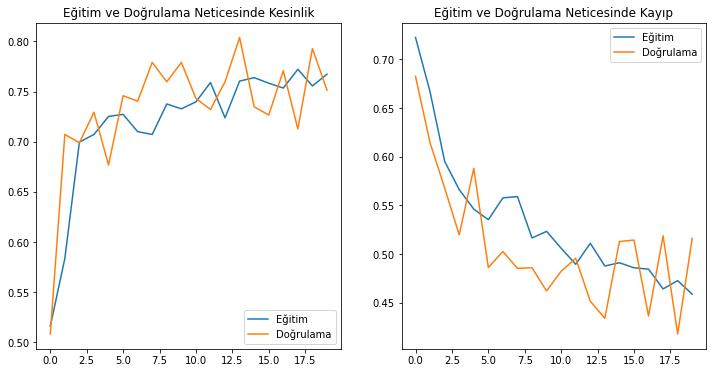

In [43]:
# Eğitim Sonuçlarının Görselleştirilmesi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim')
plt.plot(epochs_range, val_acc, label='Doğrulama')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Neticesinde Kesinlik')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim')
plt.plot(epochs_range, val_loss, label='Doğrulama')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Neticesinde Kayıp')
plt.show()

In [44]:
# Yeni ray verilerini tahmin için gerekli fonksiyon hazırlanıyor
def tahmin(resim, gercek):
  konum = "/content/drive/My Drive/Piton_Uygulamalarim/test/"
  konum = konum + resim

  img = tf.keras.utils.load_img(
      konum, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "GERÇEK SINIF: {} | TAHMİN EDİLEN: {} . Doğruluk Oranı: %{:.2f}"
      .format(gercek, class_names[np.argmax(score)], 100 * np.max(score))
  )

In [45]:
# Test klasöründeki tüm dosyaları okuyup tahmin edelim...
saglam_test_imgeleri = listdir("/content/drive/My Drive/Piton_Uygulamalarim/test/t_saglam/")
kirik_test_imgeleri = listdir("/content/drive/My Drive/Piton_Uygulamalarim/test/t_kirik/")

sSay = kSay = 1

for s_img in saglam_test_imgeleri:
  print(sSay, " ", end="")
  tahmin("t_saglam/" + s_img, "Saglam")
  sSay += 1

print(90 * "-")

for k_img in kirik_test_imgeleri:
  print(kSay, " ", end="")
  tahmin("t_kirik/" + k_img, "Kirik")
  kSay += 1



1  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %95.73
2  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %95.74
3  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %93.61
4  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %95.09
5  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %68.06
6  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %92.36
7  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %52.89
8  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %95.11
9  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %94.54
10  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %79.35
11  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %78.92
12  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %71.45
13  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %81.60
14  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğr